In [181]:
import tensorflow as tf
from tensorflow.keras import layers
import time
import matplotlib.pyplot as plt
import glob
import os

In [13]:
# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [19]:
next(iter(train_dataset))[0].numpy().shape

(28, 28, 1)

In [ ]:
# Generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model
# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def save_images(noise, epoch, data):
    gen_images = generator(noise, training=False)
    gen_images = (gen_images + 1) / 2 # Rescale between 0 and 1

    plt.figure(figsize=(4, 4))
    if data == 'mnist':
        plt.imshow(gen_images[0], cmap='gray') # first image, grayscale for mnist
    elif data == 'cifar10':
        plt.imshow(gen_images[0]) # retain color for cifar10
    plt.axis('off')
    plt.savefig(f'images\\{data}\\gen_image_epoch_{epoch}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

# Training function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs, data):
    if data not in ['mnist', 'cifar10']:
        raise ValueError("Please specify either 'mnist' or 'cifar10' as data variable.")
    t_start = time.time()
    t1 = time.time()
    counter = 1
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

            t2 = time.time()
            if t2 - t1 >= 10:
                noise = tf.random.normal([BATCH_SIZE, 100])
                save_images(counter, noise, epoch, data)
                counter += 1
                print('Saved images.')
                t1 = time.time()
        print(f'Epoch {epoch + 1} / {epochs} completed.')
    t_final = time.time()
    print(f'Done training {data} over {epochs} epochs in {(t_final - t_start):.0f} seconds.')

In [104]:
train(train_dataset, epochs=500, data='mnist')

Saved images.
Epoch 1 / 500 completed.
Saved images.
Epoch 2 / 500 completed.
Epoch 3 / 500 completed.
Saved images.
Epoch 4 / 500 completed.
Saved images.
Epoch 5 / 500 completed.
Epoch 6 / 500 completed.
Saved images.
Epoch 7 / 500 completed.
Saved images.
Epoch 8 / 500 completed.
Epoch 9 / 500 completed.
Saved images.
Epoch 10 / 500 completed.
Saved images.
Epoch 11 / 500 completed.
Epoch 12 / 500 completed.
Saved images.
Epoch 13 / 500 completed.
Epoch 14 / 500 completed.
Saved images.
Epoch 15 / 500 completed.
Saved images.
Epoch 16 / 500 completed.
Epoch 17 / 500 completed.
Saved images.
Epoch 18 / 500 completed.
Epoch 19 / 500 completed.
Saved images.
Epoch 20 / 500 completed.
Saved images.
Epoch 21 / 500 completed.
Epoch 22 / 500 completed.
Saved images.
Epoch 23 / 500 completed.
Epoch 24 / 500 completed.
Saved images.
Epoch 25 / 500 completed.
Saved images.
Epoch 26 / 500 completed.
Epoch 27 / 500 completed.
Saved images.
Epoch 28 / 500 completed.
Saved images.
Epoch 29 / 500 

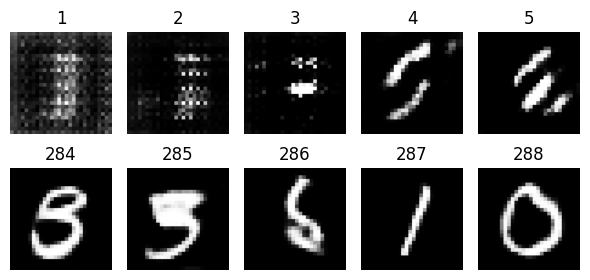

In [ ]:
first_5 = ['.\\images\\mnist\\gen_image_1_epoch_0.png',
           '.\\images\\mnist\\gen_image_2_epoch_1.png',
           '.\\images\\mnist\\gen_image_3_epoch_3.png',
           '.\\images\\mnist\\gen_image_4_epoch_4.png',
           '.\\images\\mnist\\gen_image_5_epoch_6.png']

last_5 = ['.\\images\\mnist\\gen_image_284_epoch_490.png',
          '.\\images\\mnist\\gen_image_285_epoch_492.png',
          '.\\images\\mnist\\gen_image_286_epoch_494.png',
          '.\\images\\mnist\\gen_image_287_epoch_496.png',
          '.\\images\\mnist\\gen_image_288_epoch_498.png']

fig, axs = plt.subplots(2, 5, figsize=(6, 3))
x = 284
for i, (img_path_first, img_path_last) in enumerate(zip(first_5, last_5)):
    img_first = plt.imread(img_path_first)
    img_last = plt.imread(img_path_last)
    
    axs[0, i].imshow(img_first, cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title(f'{i + 1}')
    axs[1, i].imshow(img_last, cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title(f'{x}')
    x += 1

plt.tight_layout()

In [225]:
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.reshape(-1, 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)

In [226]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
# Generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model
# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def save_images(iteration, noise, epoch, data):
    gen_images = generator(noise, training=False)
    gen_images = (gen_images + 1) / 2 # Rescale between 0 and 1
    gen_images = gen_images.numpy().astype('float32')

    plt.figure(figsize=(4, 4))
    if data == 'mnist':
        plt.imshow(gen_images[0], cmap='gray') # first image, grayscale for mnist
    elif data == 'cifar10':
        plt.imshow(gen_images[0]) # retain color for cifar10
    plt.axis('off')
    plt.savefig(f'images\\{data}\\gen_image_{iteration}_epoch_{epoch+1}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

# Training function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

epoch_var = tf.Variable(0, dtype=tf.uint16)
checkpoint_dir = '.\\checkpoints\\'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 epoch=epoch_var)

if tf.train.latest_checkpoint(checkpoint_dir):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print(f'Checkpoint restored from epoch {epoch_var.numpy()+1}')

def clean_checkpoints():
    # Each checkpoint file is 40 MB or more and I care about only the most recent anyway
    checkpoints = sorted(glob.glob(os.path.join(checkpoint_dir, "ckpt-*")),
                         key=lambda x: int(x.split('-', maxsplit=1)[1].split('.')[0]))
    
    if len(checkpoints) > 1:
        for ckpt in checkpoints[:-2]:  # Keep only the latest, 2 files per checkpoint
            os.remove(ckpt)

# Training loop
def train(dataset, epochs, data):
    if data not in ['mnist', 'cifar10']:
        raise ValueError("Please specify either 'mnist' or 'cifar10' as data variable.")
    t_start = time.time()

    # Train
    for epoch in range(epoch_var.numpy(), epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Save every 10 epochs
        if epoch % 10 == 0:
            noise = tf.random.normal([BATCH_SIZE, 100])
            save_images(noise, epoch, data)
            print(f'Saved images.')

        # Saves checkpoint each epoch
        epoch_var.assign(epoch)
        checkpoint.save(file_prefix=checkpoint_dir+'ckpt')
        clean_checkpoints()
        print(f'Epoch {epoch + 1} / {epochs} completed. Checkpoint saved.')

    t_final = time.time()
    print(f'Done training {data} over {epochs} epochs in {(t_final - t_start):.0f} seconds.')

Checkpoint restored from epoch 1102


In [298]:
train(train_dataset, epochs=3000, data='cifar10')

Saved images.
Saved images.
Epoch 1102 / 3000 completed. Checkpoint saved.
Saved images.
Saved images.
Epoch 1103 / 3000 completed. Checkpoint saved.
Saved images.
Epoch 1104 / 3000 completed. Checkpoint saved.
Saved images.
Saved images.
Epoch 1105 / 3000 completed. Checkpoint saved.
Saved images.
Epoch 1106 / 3000 completed. Checkpoint saved.
Saved images.
Saved images.
Epoch 1107 / 3000 completed. Checkpoint saved.
Saved images.
Saved images.
Epoch 1108 / 3000 completed. Checkpoint saved.
Saved images.
Epoch 1109 / 3000 completed. Checkpoint saved.
Saved images.
Saved images.
Saved images.
Epoch 1110 / 3000 completed. Checkpoint saved.
Saved images.
Epoch 1111 / 3000 completed. Checkpoint saved.
Saved images.
Saved images.
Epoch 1112 / 3000 completed. Checkpoint saved.
Saved images.
Epoch 1113 / 3000 completed. Checkpoint saved.
Saved images.
Epoch 1114 / 3000 completed. Checkpoint saved.
Epoch 1115 / 3000 completed. Checkpoint saved.
Saved images.
Epoch 1116 / 3000 completed. Check

KeyboardInterrupt: 

In [ ]:
cifar10_images = sorted(glob.glob('.\\images\\cifar10\\*.png'), key=lambda x: int(x.split('.')[1].split('_')[-1]))
first_5 = cifar10_images[:5]
last_5 = cifar10_images[-5:]

['.\\images\\cifar10\\gen_image_287_epoch_1735.png', '.\\images\\cifar10\\gen_image_288_epoch_1737.png', '.\\images\\cifar10\\gen_image_289_epoch_1739.png', '.\\images\\cifar10\\gen_image_290_epoch_1741.png', '.\\images\\cifar10\\gen_image_291_epoch_1743.png']


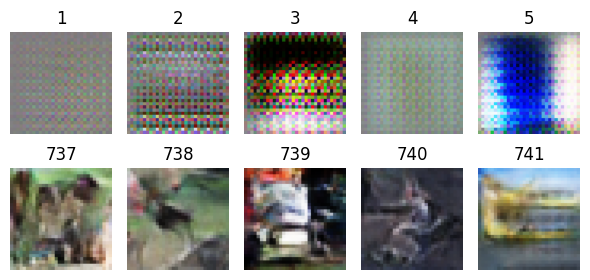

In [303]:
x = 737 # 741 total images, showing last 5
fig, axs = plt.subplots(2, 5, figsize=(6, 3))
for i, (img_path_first, img_path_last) in enumerate(zip(first_5, last_5)):
    img_first = plt.imread(img_path_first)
    img_last = plt.imread(img_path_last)
    
    axs[0, i].imshow(img_first)
    axs[0, i].axis('off')
    axs[0, i].set_title(f'{i + 1}')
    axs[1, i].imshow(img_last)
    axs[1, i].axis('off')
    axs[1, i].set_title(f'{x}')
    x += 1

plt.tight_layout()